In [1]:
#!pip install fasttext
!rm -rf ReST/
!git clone https://github.com/alessandrocuda/ReSt
!wget http://www.italianlp.it/twitter128.bin
!mv /content/twitter128.bin /content/ReSt/results/model/word2vec

Cloning into 'ReSt'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 207 (delta 44), reused 89 (delta 28), pack-reused 87
Receiving objects: 100% (207/207), 79.64 MiB | 28.26 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Checking out files: 100% (81/81), done.
--2021-04-08 15:52:51--  http://www.italianlp.it/twitter128.bin
Resolving www.italianlp.it (www.italianlp.it)... 146.48.92.46, 2a00:1620:c0:5c::8
Connecting to www.italianlp.it (www.italianlp.it)|146.48.92.46|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613808129 (585M) [application/octet-stream]
Saving to: ‘twitter128.bin’

twitter128.bin      100%[===================>] 585.37M  10.5MB/s    in 46s     

2021-04-08 15:53:38 (12.6 MB/s) - ‘twitter128.bin’ saved [613808129/613808129]



In [2]:
import tensorflow as tf
#import tensorflow_addons as tfa

from tensorflow.keras import backend as K

#from tensorflow.keras.engine import Layer, InputSpec, InputLayer

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Dropout, Embedding, concatenate
from tensorflow.keras.layers import Conv1D, MaxPool1D, Conv2D, MaxPool2D, ZeroPadding1D, GlobalMaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Input, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Concatenate, Dot, Concatenate, Multiply, RepeatVector
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Lambda, Permute
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from gensim.models import KeyedVectors
from gensim.models import Word2Vec

#import fasttext.util

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.test.utils import datapath

import sys
root_project = "/content/ReSt/"
#root_project = "/Users/Alessandro/Dev/repos/ReSt/"
#root_project = "/home/jupyter/SaRaH/"
sys.path.append(root_project)
from src.data.utils import load_csv_to_dict, set_unkmark_token
from src.data.word_embedding import get_index_key_association, get_int_seq, build_keras_embedding_matrix, get_data_to_emb

%load_ext autoreload
%autoreload 2

In [3]:
print(tf.__version__)

2.4.1


# Path

In [5]:
#PATH
dataset_dev_path           = root_project + "dataset/haspeede2/preprocessed/dev/dev.csv"
dataset_test_tweets_path   = root_project + "dataset/haspeede2/preprocessed/reference/reference_tweets.csv"
w2v_bin_path               = root_project + 'results/model/word2vec/twitter128.bin'

In [6]:
#load dataset dictionary
dataset_dev = load_csv_to_dict(dataset_dev_path)
dataset_test_tweets = load_csv_to_dict(dataset_test_tweets_path)

In [7]:
dataset_dev.keys()

dict_keys(['id', 'text', 'hs', 'stereotype', 'processed_text', 'text_length', 'hashtags', '%CAPS-LOCK words', 'esclamations', 'questions', 'tokens', 'lemma', 'pos', 'dep', 'word_polarity', 'sentence_positive', 'sentence_negative', 'sentence_neutral', 'stem', '%bad_words'])

# Embedding

In [8]:
#load word2vec and embedding_matrix
w2v = KeyedVectors.load_word2vec_format(datapath(w2v_bin_path), binary=True)
index_to_key, key_to_index = get_index_key_association(w2v)
embedding_matrix, vocab_size = build_keras_embedding_matrix(w2v, index_to_key)

WORD_EMB_SIZE = 128
VOCAB_SIZE = vocab_size

Vocab_size is 1170776
Embedding_matrix with unk word loaded
Shape (1170777, 128)


In [14]:
def get_index_key_pos_association(X):
    key_to_index = {"<UNK>": 0}
    index_to_key = {0: "<UNK>"}
    unique_pos = set([pos for words in X for pos in words])

    for idx, word in enumerate(sorted(unique_pos)):
        key_to_index[word]  = idx+1 # which row in `weights` corresponds to which word?
        index_to_key[idx+1] = word # which row in `weights` corresponds to which word?
    return index_to_key, key_to_index

def get_one_hot_pos(index_to_key_pos):
  index_to_onehot_pos = {}
  for idx in index_to_key_pos.keys():
    ohe = [0 for _ in range(len(index_to_key_pos.keys()))]
    ohe[idx] = 1
    index_to_onehot_pos[idx]  = ohe # which row in `weights` corresponds to which word?
  return index_to_onehot_pos

index_to_key_pos, key_to_index_pos = get_index_key_pos_association(X = dataset_dev["pos"])
index_to_onehot_pos = get_one_hot_pos(index_to_key_pos)

In [11]:
dataset_dev.keys()

dict_keys(['id', 'text', 'hs', 'stereotype', 'processed_text', 'text_length', 'hashtags', '%CAPS-LOCK words', 'esclamations', 'questions', 'tokens', 'lemma', 'pos', 'dep', 'word_polarity', 'sentence_positive', 'sentence_negative', 'sentence_neutral', 'stem', '%bad_words'])

# DATA

In [15]:
def load_data(dataset_dict, w2v, key_to_index, embedding_matrix, max_text_len):
    senteces = dataset_dict["tokens"]
    X = dataset_dict["tokens"]
    X = set_unkmark_token(X, w2v.vocab)
    X = get_int_seq(X, key_to_index)
    X = pad_sequences(X, maxlen=MAX_TEXT_LEN, padding='post', truncating='post')
    X = np.array(X)
    
    X_pos = dataset_dict["pos"]
    X_pos = set_unkmark_token(X_pos, key_to_index_pos)
    X_pos = get_int_seq(X_pos, key_to_index_pos)
    X_pos = pad_sequences(X_pos, maxlen=MAX_TEXT_LEN, padding='post', truncating='post')
    X_pos = np.array(X_pos)

    extra_feature = np.array([dataset_dict["hashtags"], dataset_dict["%CAPS-LOCK words"], dataset_dict["esclamations"], dataset_dict["questions"], dataset_dict["sentence_positive"], dataset_dict["sentence_negative"], dataset_dict["sentence_neutral"], dataset_dict["%bad_words"]]).T

    y = np.array(dataset_dict["stereotype"])
    return X, X_pos, extra_feature, y

def to_emb(X, embedding):
    return np.array([ [ embedding[index_word] for index_word in sentence] for sentence in X])

In [17]:
#load dev/test
MAX_TEXT_LEN = 65

X, X_pos, X_extra_feature, y = load_data(dataset_dev, w2v, key_to_index, embedding_matrix, MAX_TEXT_LEN)
X_e = to_emb(X, embedding_matrix)
X_pos_e = to_emb(X_pos, index_to_onehot_pos)

X_test, X_test_pos, X_test_extra_feature, y_test = load_data(dataset_test_tweets, w2v, key_to_index, embedding_matrix, MAX_TEXT_LEN)
X_test_e = to_emb(X_test, embedding_matrix)
X_test_pos_e = to_emb(X_test_pos, index_to_onehot_pos)

# Split

In [18]:
X_train, X_val, X_pos_train, X_pos_val, X_extra_feature_train, X_extra_feature_val, y_train, y_val = train_test_split(X_e, X_pos_e, X_extra_feature, y, test_size=0.10, random_state=128)

# Metrics

In [19]:
def f1_sklean_mapping_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def f1_macro(y_true, y_pred):
    return tf.py_function(f1_sklean_mapping_macro, (y_true, K.round(y_pred)), tf.double)

# callback

In [20]:
class FCallback(tf.keras.callbacks.Callback):
  
    def __init__(self, validation = (), verbose = 0):
        self.validation = validation
        self.verbose = verbose

    def on_train_begin(self, logs={}):
        self.f1 = []
        self.val_f1 = []
    def on_epoch_end(self, epoch, logs=None):
        y_t =  self.validation[1]
        y_p =  np.where(self.model.predict(self.validation[0]) > 0.5, 1, 0)
        logs['val_f1'] =  f1_score(y_t, y_p, average='macro')
        if self.verbose >0:
            print("— val_f1: {}".format(logs['val_f1']))

class ReturnBestEarlyStopping(EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

# KIM-CNN

In [33]:
def kim_cnn_pos(input_shape, filters = 256, filter_sizes = [2,4,6], dropout = 0.5, hn=128, lr=0.01, print_model=False):
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D
    from tensorflow.keras.layers import Dense, Input, Flatten, Activation
    from tensorflow.keras.layers import Concatenate
    from tensorflow.keras.regularizers import l2

    """ HyperParameters """

    text_seq_input = Input(shape=input_shape, name="text")
    pos_seq_input = Input(shape=(65,17, ), name="pos")
    extra_feature = Input(shape=(8,), name="extra")

    convs = []
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=filters, kernel_size=filter_size)(text_seq_input)
        l_relu = Activation("relu")(l_conv)
        l_pool = GlobalMaxPool1D()(l_relu)   
        convs.append(l_pool)
    
    convs_pos = []
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=filters, kernel_size=filter_size)(pos_seq_input)
        l_relu = Activation("relu")(l_conv)
        l_pool = GlobalMaxPool1D()(l_relu)   
        convs_pos.append(l_pool)

    l_merge     = Concatenate(axis=1)(convs)
    l_flat      = Flatten()(l_merge)
    l_merge_pos = Concatenate(axis=1)(convs_pos)
    l_flat_pos  = Flatten()(l_merge_pos)

    input_ff    = Concatenate(axis=1)([l_flat, l_flat_pos, extra_feature])
    l_drop      = Dropout(dropout)(input_ff)
    l_hidden    = Dense(hn, activation='relu')(l_drop)
    l_drop      = Dropout(dropout)(l_hidden)
    l_out_st    = Dense(1, activation='sigmoid', name="st")(l_drop)  #dims output

    model_cnn   = Model(inputs=[text_seq_input, pos_seq_input, extra_feature], outputs=l_out_st)
    if print_model:
        model_cnn.summary()
        tf.keras.utils.plot_model(model_cnn, "my_first_model.png", show_shapes=True)
    
    model_cnn.compile(
        loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=False),
    )

    return model_cnn

In [1]:
#del model
model = kim_cnn_pos((65,128, ), filters = 128, filter_sizes = [2,3,4], dropout = 0.5, hn=256, lr=0.001, print_model=True)

NameError: ignored

In [ ]:
input_train = {"text": X_train, "pos": X_pos_train, "extra": X_extra_feature_train}
input_val = {"text": X_val, "pos": X_pos_val, "extra": X_extra_feature_val}
input_test = {"text": X_test_e, "pos": X_test_pos_e, "extra": X_test_extra_feature}

f1_callback = FCallback(validation = (input_test, y_test), verbose=True)                                   
best_callback = ReturnBestEarlyStopping(monitor="val_loss", min_delta=0, patience=100, verbose=1, mode="min", restore_best_weights=True)

history = model.fit(input_train, y_train, batch_size=64, epochs=200, validation_data=(input_val, y_val), callbacks=[f1_callback, best_callback], verbose = 1)

Epoch 1/200


In [49]:
y_val_pred = np.where(model.predict(input_val) >0.5,1,0)
print(f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred))

0.6928879310344827
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       369
           1       0.64      0.77      0.70       315

    accuracy                           0.69       684
   macro avg       0.70      0.70      0.69       684
weighted avg       0.71      0.69      0.69       684



In [50]:
y_test_pred = np.where(model.predict(input_test) > 0.5, 1, 0)
print(y_test.shape)
print(f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred))

(1263,)
0.6675825573056794
              precision    recall  f1-score   support

           0       0.83      0.50      0.63       694
           1       0.59      0.88      0.71       569

    accuracy                           0.67      1263
   macro avg       0.71      0.69      0.67      1263
weighted avg       0.72      0.67      0.66      1263



|        	|        	|              	|    0   	|        	|        	|    1   	|        	|        	|          	|
|--------	|--------	|--------------	|:------:	|:------:	|:------:	|:------:	|:------:	|:------:	|:--------:	|
|        	|        	|              	|    P   	|    R   	|   F1   	|    P   	|    R   	|   F1   	| **Macro-F1** 	|
| **TASK B** 	|  **News**  	| Baseline_MFC 	|   0,65 	|      1 	| 0,7878 	|      0 	|      0 	|      0 	|   0,3939 	|
|        	|        	| Baseline_SVC 	| 0,7467 	| 0,8707 	| 0,8039 	| 0,6528 	| 0,4514 	| 0,5337 	|   0,6688 	|
|        	| **Tweets** 	| Baseline_MFC 	| 0,5494 	|      1 	| 0,7092 	|      0 	|      0 	|      0 	|   0,3546 	|
|        	|        	| Baseline_SVC 	| 0,7869 	| 0,6599 	| 0,7178 	| 0,6534 	|  0,782 	|  0,712 	|   0,7149 	|

dict_keys(['loss', 'val_loss', 'val_f1'])


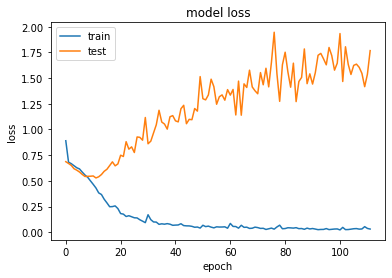

In [38]:
print(history.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Result GridSearch

In [ ]:
import pickle

grid_result0 = pickle.load( open( "../../script/result_kim_cnn_0.p", "rb" ) )
grid_result1 = pickle.load( open( "../../script/result_kim_cnn_1.p", "rb" ) )
grid_result2 = pickle.load( open( "../../script/result_kim_cnn_2.p", "rb" ) )

In [ ]:
grid_result0[0]

{'hyper_parm': {'filters': 32,
  'filter_sizes': [2, 3, 4],
  'dropout': 0.1,
  'hn': 64,
  'lr': 0.1},
 'mean': 0.3568288921589145,
 'std': 0.005373049976030892,
 'folds': {'fold_0': {'f1': 0.35859186796911474,
   'val_f1': 0.34888148500713945},
  'fold_1': {'f1': 0.3553483553483553, 'val_f1': 0.36490250696378834},
  'fold_2': {'f1': 0.355181347150259, 'val_f1': 0.35985025737014503},
  'fold_3': {'f1': 0.356348590638738, 'val_f1': 0.35623529411764704},
  'fold_4': {'f1': 0.35854161298634374, 'val_f1': 0.35427491733585265}}}

In [ ]:
grid_result_d = {
    'hyper_parm' : [],
    'mean': [],
    'std': [],
    'folds': []
}
for elem in grid_result0:
    for k in grid_result_d:
        grid_result_d[k].append(elem[k])
for elem in grid_result1:
    for k in grid_result_d:
        grid_result_d[k].append(elem[k])
for elem in grid_result2:
    for k in grid_result_d:
        grid_result_d[k].append(elem[k])

In [ ]:
df_result = pd.DataFrame(grid_result_d)

In [ ]:
pd.set_option('display.max_colwidth', None)
df_result.sort_values(by=['mean'], ascending=False)[0:20][["hyper_parm","mean", "std"]]

,hyper_parm,mean,std
231,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 64, 'lr': 0.0001}",0.705910,0.004856
218,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.1, 'hn': 64, 'lr': 0.001}",0.703817,0.011898
234,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 124, 'lr': 0.001}",0.703300,0.005910
254,"{'filters': 256, 'filter_sizes': [3, 4, 5], 'dropout': 0.1, 'hn': 64, 'lr': 0.001}",0.698973,0.009021
127,"{'filters': 128, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 124, 'lr': 0.0001}",0.698614,0.010202
274,"{'filters': 256, 'filter_sizes': [3, 4, 5], 'dropout': 0.5, 'hn': 512, 'lr': 0.001}",0.698546,0.007799
271,"{'filters': 256, 'filter_sizes': [3, 4, 5], 'dropout': 0.5, 'hn': 124, 'lr': 0.0001}",0.698533,0.012795
14,"{'filters': 32, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 64, 'lr': 0.001}",0.698085,0.015261
230,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 64, 'lr': 0.001}",0.697862,0.013440
126,"{'filters': 128, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 124, 'lr': 0.001}",0.697779,0.010987


In [ ]:
model = kim_cnn((65,128, ), filters = 256, filter_sizes = [2,3,4], dropout = 0.5, hn=64, lr=0.0001, print_model=False)
best_callback = ReturnBestEarlyStopping(monitor="val_loss", min_delta=0, patience=100, verbose=1, mode="min", restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_val, y_val), callbacks=[best_callback], verbose = 1)

In [ ]:
print(model.evaluate(X_train, y_train))
print(model.evaluate(X_val, y_val))
print(model.evaluate(X_test, y_test))
plot_history(history)

# ensemble predictions

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [ ]:
cv_kfold = StratifiedKFold(n_splits=5, shuffle=True)

models = []
X = X_train
X_extra = X_train2
y = y_train
test   = {"text": X_val, "extra": X_val2}

y_test = y_val

for train_index, test_index in cv_kfold.split(X, y):
  model = build_model()
  model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      #optimizer=tf.keras.optimizers.Adam(learning_rate=0.007, amsgrad=True),
      optimizer = tf.keras.optimizers.SGD(learning_rate=0.007, momentum=0.4, nesterov=True),
      metrics=["accuracy"]
  )
  input_train = {"text": X[train_index], "extra": X_extra[train_index]}
  input_val   = {"text": X[test_index], "extra": X_extra[test_index]}
  y_train = y[train_index]
  y_val = y[test_index]
  f1_callback1 = ROCCallback(validation = (input_val, y_val), verbose = 0)                                   
  best_callback1 = ReturnBestEarlyStopping(monitor="val_f1",
                                          min_delta=0,
                                          patience=200,
                                          verbose=0,
                                          mode="max",
                                          #baseline=0.72,
                                          restore_best_weights=True)
  model.fit(input_train, y_train, batch_size=128, epochs=200, validation_data=(input_val, y_val), callbacks=[f1_callback1, best_callback1], verbose=0)
  y_test_pred = np.where(model.predict(test) >0.5,1,0)
  print(f1_score(y_test,y_test_pred,average="macro"))
  models.append(model)


0.7020388105758069
0.7397104473272389
0.7321598940789346
0.7251979246114018
0.7258058638290028


In [ ]:
def ensemble_predictions(members, testX):
  # make predictions
  results = []
  yhats = [np.squeeze(np.where(models[0].predict(test) > 0.5, 1,0).reshape(1,-1)) for model in members]
  # sum across ensemble members
  yhats = np.array(yhats)
  print(yhats.shape)

  for i in range(yhats.shape[1]):
    counts = np.bincount(yhats[:,i])
    results.append(np.argmax(counts))
  # argmax across classes
  return results

In [ ]:
y_pred = ensemble_predictions(models, test)
print(classification_report(y_test,y_pred))


(5, 684)
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       370
           1       0.67      0.70      0.68       314

    accuracy                           0.70       684
   macro avg       0.70      0.70      0.70       684
weighted avg       0.70      0.70      0.70       684

